# Deep Q learning

## Algorithm

<img src="./images/deep-q-learning.png" width=500 height=500 style="float: left"/>

## Reference

V. Mnih et al. Human-level control through deep reinforcement learning. *Nature*, 518(7540): 529–533, 02 2015. 

### Modules and packages

In [2]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

import tensorflow as tf

import gym

import warnings
warnings.filterwarnings("ignore")

### Deep Q-network (DQN) agent

In [3]:
class DQNAgent(object):

    def __init__(self, env, model, target_model, optimizer):

        self.num_episodes = 1000
        self.gamma = 0.99  # discount rate
        self.epsilon = 0.1  # exploration rate
        self.memory = deque(maxlen=10000)
        self.batch_size = 32
        
        # agent's environment 
        self.env = env
        self.state_size = len(env.observation_space.low)
        self.action_size = env.action_space.n

        # models and optimizer
        self.optimizer = optimizer
        self.model = model # used to select action
        self.target_model = target_model # used to evaluate action
        self.target_model.set_weights(self.model.get_weights()) # set equal parameters

        self.target_update_counter = 0  # count steps for updating target network
        self.target_update_frequency = 200  # number of steps for updating target model

        self.stats = {'rewards': []} 
        self.verbose = 50  # negative - not to show; positive - show specific episode
        self.to_show = 200  # negative - not to show; positive - show specific episode

    def execute(self):

        # for each episode
        for episode in range(1, self.num_episodes + 1):
            
            # init episode stats
            self.stats['rewards'].append(0)
            
            # get initial state
            state = self.env.reset()

            # for each time step in the episode (or until terminal state)
            while True:

                # for the current state, select action using Q(s,a)
                action = self.select_action(state, self.epsilon)

                # carry out action, observe new state and reward
                new_state, reward, done, _ = self.env.step(action)

                # put into agents memory
                self.memory.append((state, action, reward, new_state, done))

                # train agent's main model (every step)
                self.train()

                # If counter reaches set value, update target network with weights of main network
                self.target_update_counter += 1
                if self.target_update_counter == self.target_update_frequency:                    
                    self.target_update_counter = 0
                    self.target_model.set_weights(self.model.get_weights())

                # update episode stats
                self.stats['rewards'][-1] += reward
                
                # decide whether to continue episode
                if done:
                    break
                else:  # update state
                    state = new_state          

            # print stats on screen
            if self.verbose > 0 and episode % self.verbose == 0:
                print("episode: {}\t reward: {:.2f}".format(episode, self.stats['rewards'][-1]))

            # show simulated environment with learned parameters
            if self.to_show > 0 and episode % self.to_show == 0:
                self.act()

    # train main model
    def train(self):
        
        if len(self.memory) < self.batch_size:
            return
        
        # select minibach for training
        minibatch = random.sample(self.memory, self.batch_size)

        states = np.array([tup[0] for tup in minibatch], dtype=np.float32)
        actions = np.array([tup[1] for tup in minibatch])
        rewards = np.array([tup[2] for tup in minibatch])
        next_states = np.array([tup[3] for tup in minibatch])
        done = np.array([tup[4] for tup in minibatch])
        
        
        with tf.GradientTape() as tape:
            # tensor of predicted Q values
            predicted = self.model(states)
            
            # take numpy arrays of predicted values
            q_values = predicted.numpy()
            
            # Q values in the new state
            q_new = self.target_model.predict(next_states)
        
            # target Q values
            q_target = rewards + self.gamma * (1 - done) * np.amax(q_new, axis=1)            
            
            # update array puting target values
            q_values[range(len(actions)), actions] = q_target
            
            # convert to tensor of target Q values
            target = tf.convert_to_tensor(q_values, dtype=np.float32)
                
            # loss function             
            err = target - predicted
            loss = 1./self.batch_size * tf.reduce_sum(err**2)
            
        # Get the gradients
        variables = self.model.trainable_variables
        gradients = tape.gradient(loss, variables)
        
        # Update the weights
        self.optimizer.apply_gradients(zip(gradients, variables))

    # select action using epsilon greedy policy
    def select_action(self, state, epsilon):
        if np.random.random() < epsilon:
            # Exploration: randomly selected action
            action = np.random.randint(0, self.action_size)
        else:
            # Greedy selection: action with max Q(s,a)
            q_values = self.model.predict(np.array(state).reshape(1, -1))
            action = np.argmax(q_values)
        return action

    def act(self):
        total_reward = 0
        state = self.env.reset()
        done = False
        while not done:
            action = self.select_action(state, 0)
            state, reward, done, _ = self.env.step(action)
            total_reward += reward
            self.env.render()
        self.env.close()
        return total_reward

### Neural network model to approximate action value function

In [4]:
def build_model(state_size, action_size):
    
    # computaion graph
    x = tf.keras.layers.Input(shape=(state_size,))
    h = tf.keras.layers.Dense(32, activation='relu')(x)
    y = tf.keras.layers.Dense(action_size, activation='linear')(h)

    # model and optimizer
    model = tf.keras.models.Model(inputs=x, outputs=y)
    optimizer = tf.keras.optimizers.Adam(lr=0.001)
    
    return model, optimizer

### Example

In [5]:
env = gym.make("CartPole-v0")

state_size = len(env.observation_space.low)
action_size = env.action_space.n

model, optimizer = build_model(state_size, action_size) # used to select action
target_model, _ = build_model(state_size, action_size) # used to evaluate action

agent = DQNAgent(env, model, target_model, optimizer)
agent.execute()
agent.act()

episode: 50	 reward: 9.00
episode: 100	 reward: 9.00
episode: 150	 reward: 10.00
episode: 200	 reward: 67.00
episode: 250	 reward: 116.00
episode: 300	 reward: 200.00
episode: 350	 reward: 155.00
episode: 400	 reward: 80.00
episode: 450	 reward: 63.00
episode: 500	 reward: 157.00
episode: 550	 reward: 200.00
episode: 600	 reward: 200.00
episode: 650	 reward: 200.00
episode: 700	 reward: 200.00
episode: 750	 reward: 200.00
episode: 800	 reward: 59.00
episode: 850	 reward: 200.00
episode: 900	 reward: 200.00
episode: 950	 reward: 200.00
episode: 1000	 reward: 200.00


200.0

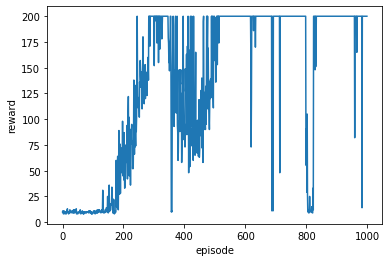

In [6]:
plt.plot(agent.stats['rewards'])
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()